In [ ]:
# Load data science packages
import numpy as np
import pandas as pd

# Load argument packages
import argparse
import re

# Load chemistry packages
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem import PandasTools
from rdkit import RDLogger                                                                                                                                                               

RDLogger.DisableLog('rdApp.*')
PandasTools.RenderImagesInAllDataFrames(images=True)

# Load visualization package and display settings
import matplotlib.pyplot as plt
IPythonConsole.molSize = (1000, 300)   # Change image size
IPythonConsole.ipython_useSVG = False  # Show as PNG

class NotCanonicalizableSmilesException(ValueError):
    pass

def canonicalize_smi(smi: str, remove_atom_mapping=False, individual=False) -> str:
    """ Convert a SMILES string into its canonicalized form
    Args:
        smi: Reaction SMILES
        remove_atom_mapping: If True, remove atom mapping information from the canonicalized SMILES output
    Returns:
        SMILES reaction, canonicalized, as a string
    """
    mol = Chem.MolFromSmiles(smi)
    if not mol:
        if individual == False:
            return smi
        elif individual == True:
            return
        else:
            print("Error: individual must be True or False")
    if remove_atom_mapping:
        for atom in mol.GetAtoms():
            if atom.HasProp("molAtomMapNumber"):
                atom.ClearProp("molAtomMapNumber")
    return Chem.MolToSmiles(mol)

def canonicalize_reagents(reagents_list):
    canon_reagents_list = []
    for reagents in reagents_list:
        canon_reagents_list.append('.'.join([canonicalize_smi(reagent) for reagent in reagents.split('.')]))
    
    return canon_reagents_list
        
# Paths
PATH      = '/home/fjaume/MolecularTransformer/'
PATH_tgt  = PATH + 'data/MIT_reagent_pred/tgt-test.txt'
PATH_pred = PATH + 'experiments/results/predictions_MIT_reagent_pred_model_average_20_on_MIT_reagent_pred_test.txt'
PATH_train  = PATH + 'data/MIT_reagent_pred/tgt-train.txt'

# Load data
tgt   = canonicalize_reagents(pd.read_csv(PATH_tgt, header=None).replace('\s+', '', regex=True).values.flatten().tolist())
pred  = canonicalize_reagents(pd.read_csv(PATH_pred, header=None).replace('\s+', '', regex=True).values.flatten().tolist())
train = canonicalize_reagents(pd.read_csv(PATH_train, header=None).replace('\s+', '', regex=True).values.flatten().tolist())

# Calculate accuracy
accuracy = []
for n in range(len(tgt)):
    
    reagents_tgt  = set(tgt[n].split('.'))
    reagents_pred = set(pred[n].split('.'))
    
    accuracy.append(len([reagent for reagent in reagents_pred if reagent in reagents_tgt]) / len(set(tgt[n].split('.'))))

accuracy = 100*np.array(accuracy)

correc_preds = np.array(pred)[np.argwhere(accuracy == 100)].flatten()
correc_tgt = np.array(tgt)[np.argwhere(accuracy == 100)].flatten()

reagents_in_tgt   = sorted(set('.'.join(tgt).split('.')))
reagents_in_pred  = [canonicalize_smi(reagent, individual=True) for reagent in sorted(set('.'.join(pred).split('.')))]
reagents_in_train = sorted(set('.'.join(train).split('.')))
reagents_not_predicted = [reagent for reagent in reagents_in_tgt if reagent not in reagents_in_pred]
reagents_not_in_tgt = [reagent for reagent in reagents_in_pred if reagent not in reagents_in_tgt]
reagents_predicted = [reagent for reagent in reagents_in_tgt if reagent in reagents_in_pred]

train_in_pred = [] 
appearances=[]
predicted=[]
not_pred=[]
totpred=[]
a = [r_tgt.split('.') for r_tgt in tgt]
b = [r_pred.split('.') for r_pred in pred]
c = [r_train.split('.') for r_train in train]

for reagent in reagents_predicted:
    appearances.append(len([n for n in a if reagent in n]))
    predicted.append(len([n for i,n in enumerate(a) if reagent in n and reagent in b[i]]))
    not_pred.append(len([n for i,n in enumerate(a) if reagent in n and reagent not in b[i]]))
    totpred.append(len([n for n in b if reagent in n]))
    train_in_pred.append(len([n for n in c if reagent in n]))
appearances = np.array(appearances)
predicted = np.array(predicted)
totpred = np.array(totpred)
not_pred = np.array(not_pred)
rdmol = [Chem.MolFromSmiles(reagent) for reagent in reagents_predicted]

Tp_element = predicted
Fp_element = (totpred - predicted) / totpred
Fn_element = not_pred

P_element  = Tp_element / (Tp_element + Fp_element) 
R_element  = Tp_element / (Tp_element + Fn_element)
F1_element = 2 * P_element * R_element / (P_element + R_element)

d = {'reagent':reagents_predicted, 'total_tgt':appearances,
     'total_pred':totpred, 'total_train':train_in_pred,
     'correct_pred':predicted, 'precision':P_element,
     'recall':R_element, 'F1':F1_element, 'rdmol':rdmol}
df = pd.DataFrame(data=d)

reagents_notrain = df[df.total_train==0].sort_values(['correct_pred'], ascending=False).head(2)
reagent1 = Chem.MolFromSmiles(reagents_notrain.reagent.values.tolist()[0])
reagent2 = Chem.MolFromSmiles(reagents_notrain.reagent.values.tolist()[1])

reagents_1_smi  = reagents_notrain.reagent.values.tolist()[0]
reagents_1_name = '2-Chloro-5-(2-nitrovinyl)thiophene'

reaction_1_smi = 'CC(C)(C)OC(=O)N1CCc2c(-c3ccc(Cl)s3)cn(Cc3ccccc3)c2CC1>NCc1ccccc1.O=[N+]([O-])C=Cc1ccc(Cl)s1>Clc1ccc(-c2cn(Cc3ccccc3)c3c2CCNCC3)s1'
reaction_2_smi = 'COC(=O)COc1ccc(SCc2ccc(OCc3ccc(F)cc3F)cc2)cc1C>OCc1ccc(OCc2ccc(F)cc2F)cc1>Cc1cc(SCc2ccc(OCc3ccc(F)cc3F)cc2)ccc1OCC(=O)O'

reagents_2_smi  = reagents_notrain.reagent.values.tolist()[1]

In [ ]:
"""# Save reaction as PNG
d2d = Chem.Draw.MolDraw2DCairo(2000,500)
d2d.DrawMolecule(reagent1)
png = d2d.GetDrawingText()
open('../figs/reagent1.png','wb+').write(png)"""

In [8]:
def smi_tokenizer(smi):
    """
    Tokenize a SMILES molecule or reaction
    """
    import re
    pattern =  "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    regex = re.compile(pattern)
    tokens = [token for token in regex.findall(smi)]
    assert smi == ''.join(tokens)
    return ' '.join(tokens)

smi_tokenizer(reagents_1_smi)

'O = [N+] ( [O-] ) C = C c 1 c c c ( Cl ) s 1'

In [17]:
reaction_1_smi = 'CC(C)(C)OC(=O)N1CCc2c(-c3ccc(Cl)s3)cn(Cc3ccccc3)c2CC1>NCc1ccccc1.O=[N+]([O-])C=Cc1ccc(Cl)s1>Clc1ccc(-c2cn(Cc3ccccc3)c3c2CCNCC3)s1'
reaction_2_smi = 'COC(=O)COc1ccc(SCc2ccc(OCc3ccc(F)cc3F)cc2)cc1C>OCc1ccc(OCc2ccc(F)cc2F)cc1>Cc1cc(SCc2ccc(OCc3ccc(F)cc3F)cc2)ccc1OCC(=O)O'


In [18]:
reaction_1 = AllChem.ReactionFromSmarts(reaction_1_smi, useSmiles=True)
reaction_2 = AllChem.ReactionFromSmarts(reaction_2_smi, useSmiles=True)

In [22]:
# Save reaction as PNG
d2d = Chem.Draw.MolDraw2DCairo(2000,500)
d2d.DrawReaction(reaction_1)
png = d2d.GetDrawingText()
open('../figs/reaction_1.png','wb+').write(png)

78427

In [23]:
# Save reaction as PNG
d2d = Chem.Draw.MolDraw2DCairo(2000,500)
d2d.DrawReaction(reaction_2)
png = d2d.GetDrawingText()
open('../figs/reaction_2.png','wb+').write(png)

53538

In [26]:
smi_tokenizer(reagents_1_smi)

'O = [N+] ( [O-] ) C = C c 1 c c c ( Cl ) s 1'

,reagent,total_tgt,total_pred,total_train,correct_pred,precision,recall,F1,rdmol
486,NCc1ccccc1,3,6,63,1,0.545455,0.333333,0.413793,

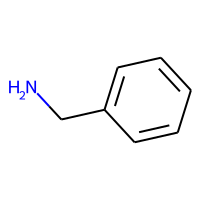

In [30]:
df[df.reagent=='N C c 1 c c c c c 1'.replace(' ', '')]